# Distribution of calibration error estimates

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/devmotion/CalibrationErrors.jl/blob/main/examples/distribution/script.jl).
The corresponding
HTML output can be viewed [here](https://devmotion.github.io/CalibrationErrors.jl/dev/examples/distribution/).*


## Packages

In [1]:
using CairoMakie
using CalibrationErrors
using Distributions
using StatsBase

using LinearAlgebra
using Random
using Statistics

CairoMakie.activate!(; type="svg")

## Introduction

This example is taken from the publication
["Calibration tests in multi-class classification: A unifying framework"](https://proceedings.neurips.cc/paper/2019/hash/1c336b8080f82bcc2cd2499b4c57261d-Abstract.html)
by Widmann, Lindsten, and Zachariah (2019).

We estimate calibration errors of the model
$$
\begin{aligned}
   g(X) &\sim \mathrm{Dir}(\alpha),\\
   Z &\sim \mathrm{Ber}(\pi),\\
   Y \,|\, g(X) = \gamma, Z = 1 &\sim \mathrm{Categorical}(\beta),\\
   Y \,|\, g(X) = \gamma, Z = 0 &\sim \mathrm{Categorical}(\gamma),
\end{aligned}
$$
where $\alpha \in \mathbb{R}_{>0}^m$ determines the distribution of
predictions $g(X)$, $\pi > 0$ determines the degree of miscalibration, and
$\beta$ defines a fixed categorical distribution.

Here we consider only the choices $\alpha = (0.1, \ldots, 0.1)$, mimicking a
distribution after training that is pushed towards the edges of the
probability simplex, and $\beta = (1, 0, \ldots, 0)$.

In our experiments we sample 250 predictions from the Dirichlet distribution
$\textrm{Dir}(\alpha)$, and then we generate corresponding labels according to
the model stated above, for different choices of $\pi$ and number of classes $m$.

We evaluate the standard estimators of expected calibration error (ECE) based on a
uniform binning scheme and a data-dependent binning scheme, and the biased estimator of
the squared kernel calibration error (SKCE), the quadratic unbiased estimator of
the SKCE, and the linear unbiased estimator of the SKCE for a specific choice of
matrix-valued kernels.

The sampling procedure and the evaluation are repeated 100 times, to obtain a sample
of 100 estimates for each considered setting of $\pi$ and $m$.

For our choice of $\alpha$ and $\beta$, the analytical ECE with respect to the
total variation distance $\|.\|_{\mathrm{TV}}$ is
$$
\mathrm{ECE}_{\mathrm{TV}} = \frac{\pi(m-1)}{m}.
$$

## Estimates

In [2]:
function estimates(estimator, π::Real, m::Int)
    # cache array for predictions, modified predictions, and labels
    predictions = [Vector{Float64}(undef, m) for _ in 1:250]
    targets = Vector{Int}(undef, 250)
    data = (predictions, targets)

    # define sampler of predictions
    sampler_predictions = sampler(Dirichlet(m, 0.1))

    # initialize estimates
    estimates = Vector{Float64}(undef, 100)

    # for each run
    @inbounds for i in eachindex(estimates)
        # sample predictions
        rand!.((sampler_predictions,), predictions)

        # sample targets
        for (j, p) in enumerate(predictions)
            if rand() < π
                targets[j] = 1
            else
                targets[j] = rand(Categorical(p))
            end
        end

        # evaluate estimator
        estimates[i] = estimator(data)(predictions, targets)
    end

    return estimates
end;

We use a helper function to run the experiment for all desired parameter settings.

In [3]:
struct EstimatesSet
    m::Vector{Int}
    π::Vector{Float64}
    estimates::Matrix{Vector{Float64}}
end

function estimates(estimator)
    # for all combinations of m and π
    mvec = [2, 10, 100]
    πvec = [0.0, 0.5, 1.0]
    estimatesmat = estimates.((estimator,), πvec', mvec)

    return EstimatesSet(mvec, πvec, estimatesmat)
end;

As mentioned above, we can calculate the analytic expected calibration error. For the squared
kernel calibration error, we take the mean of the estimates of the unbiased quadratic
estimator as approximation of the true value.

We provide simple histogram plots of our results. The mean value of the
estimates is indicated by a solid vertical line and the analytic calibration error for the ECE
is visualized as a dashed line.

In [4]:
function plot_estimates(set::EstimatesSet; ece=false)
    # create figure
    f = Figure(; resolution=(1080, 960))

    # add subplots
    nrows, ncols = size(set.estimates)
    for (j, π) in enumerate(set.π), (i, m) in enumerate(set.m)
        # obtain data
        estimates = set.estimates[i, j]

        # create new axis
        ax = Axis(f[i, j]; xticks=LinearTicks(4))
        i < nrows && hidexdecorations!(ax; grid=false)
        j > 1 && hideydecorations!(ax; grid=false)

        # plot histogram of estimates
        h = fit(Histogram, estimates)
        barplot!(ax, h; strokecolor=:black, strokewidth=0.5)

        # indicate mean of estimates
        vlines!(ax, [mean(estimates)]; linewidth=2)

        # indicate analytic calibration error for ECE
        if ece
            vlines!(ax, [π * (m - 1) / m]; linewidth=2, linestyle=:dash)
        end
    end

    # add labels and link axes
    for (j, π) in enumerate(set.π)
        Box(f[1, j, Top()]; color=:gray90)
        Label(f[1, j, Top()], "π = $π"; padding=(0, 0, 5, 5))
        linkxaxes!(contents(f[:, j])...)
    end
    for (i, m) in enumerate(set.m)
        Box(f[i, ncols, Right()]; color=:gray90)
        Label(f[i, ncols, Right()], "$m classes"; rotation=-π / 2, padding=(5, 5, 0, 0))
        linkyaxes!(contents(f[i, :])...)
    end
    Label(f[nrows, 1:ncols, Bottom()], "calibration error estimate"; padding=(0, 0, 0, 75))
    Label(f[1:nrows, 1, Left()], "# runs"; rotation=π / 2, padding=(0, 75, 0, 0))

    return f
end;

## Kernel choice

We use a tensor product kernel consisting of an exponential kernel
$k(\mu, \mu') = \exp{(- \gamma \|p - p'\|)}$ on the space of predicted categorical
distributions and a white kernel $k(y, y') = \delta(y - y')$ on the space of targets
$\{1,\ldots,m\}$. The total variation distance is chosen as the norm on the space of
predictions, and the inverse lengthscale $\gamma$ is set according to the median
heuristic.

In [5]:
struct MedianHeuristicKernel
    distances::Matrix{Float64}
    cache::Vector{Float64}
end

function MedianHeuristicKernel(n::Int)
    return MedianHeuristicKernel(
        Matrix{Float64}(undef, n, n), Vector{Float64}(undef, (n * (n - 1)) ÷ 2)
    )
end

function (f::MedianHeuristicKernel)((predictions, targets))
    distances = f.distances
    cache = f.cache

    # compute lengthscale with median heuristic
    pairwise!(distances, TotalVariation(), predictions)
    k = 0
    @inbounds for j in axes(distances, 2), i in 1:(j - 1)
        cache[k += 1] = distances[i, j]
    end
    λ = median!(cache)

    # create tensor product kernel
    kernel_predictions = with_lengthscale(ExponentialKernel(; metric=TotalVariation()), λ)
    kernel_targets = WhiteKernel()

    return kernel_predictions ⊗ kernel_targets
end

## Expected calibration error

### Uniform binning

We start by analyzing the expected calibration error (ECE).
For our estimation we use 10 bins of uniform width in each dimension.

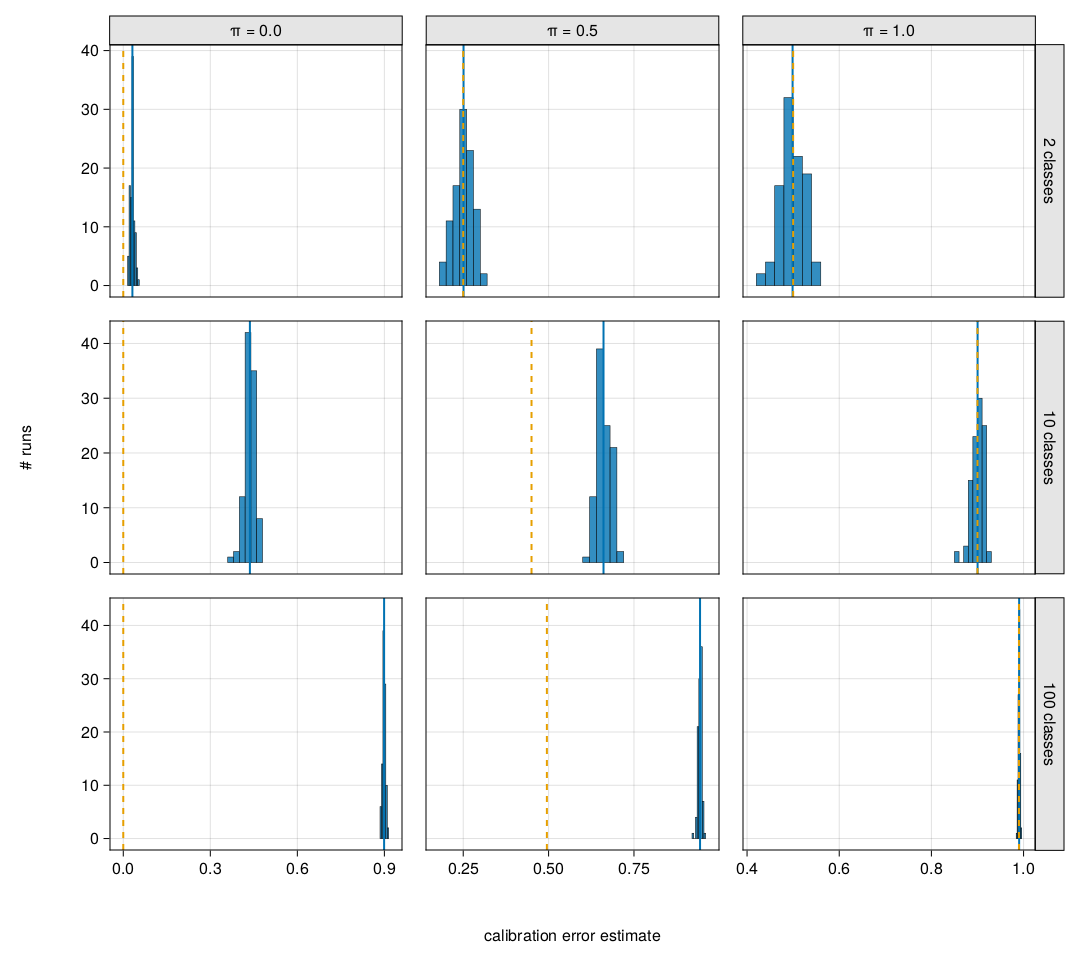

In [6]:
Random.seed!(1234)
data = estimates(_ -> ECE(UniformBinning(10), TotalVariation()))
plot_estimates(data; ece=true)

### Non-uniform binning

We repeat our experiments with a different data-dependent binning scheme. This
time the bins will be computed dynamically by splitting the predictions at the
median of the classes with the highest variance, as long as the number of bins
does not exceed a given threshold and the number of samples per bin is above
a certain lower bound. In our experiments we do not impose any restriction on
the number of bins but only stop splitting if the number of samples is less
than 10.

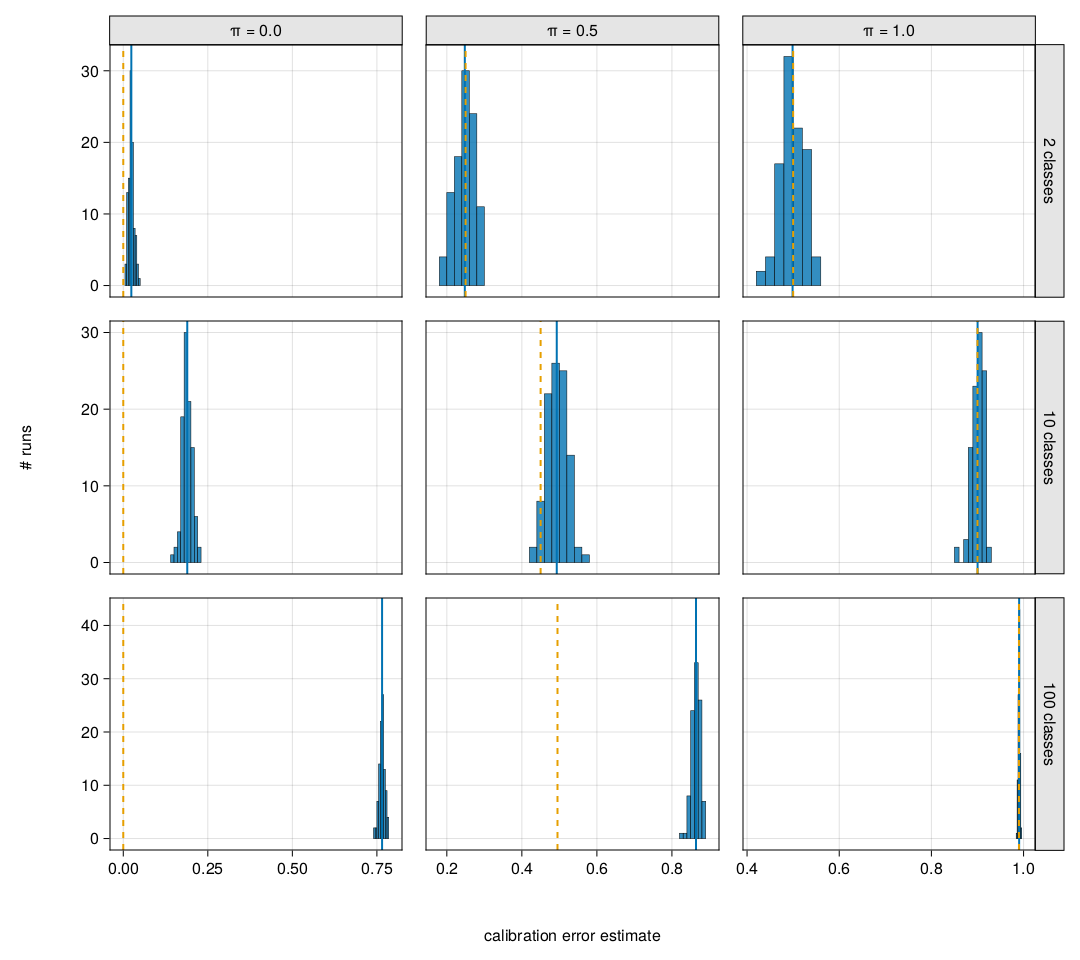

In [7]:
Random.seed!(1234)
data = estimates(_ -> ECE(MedianVarianceBinning(10), TotalVariation()))
plot_estimates(data; ece=true)

## Unbiased estimators of the squared kernel calibration error

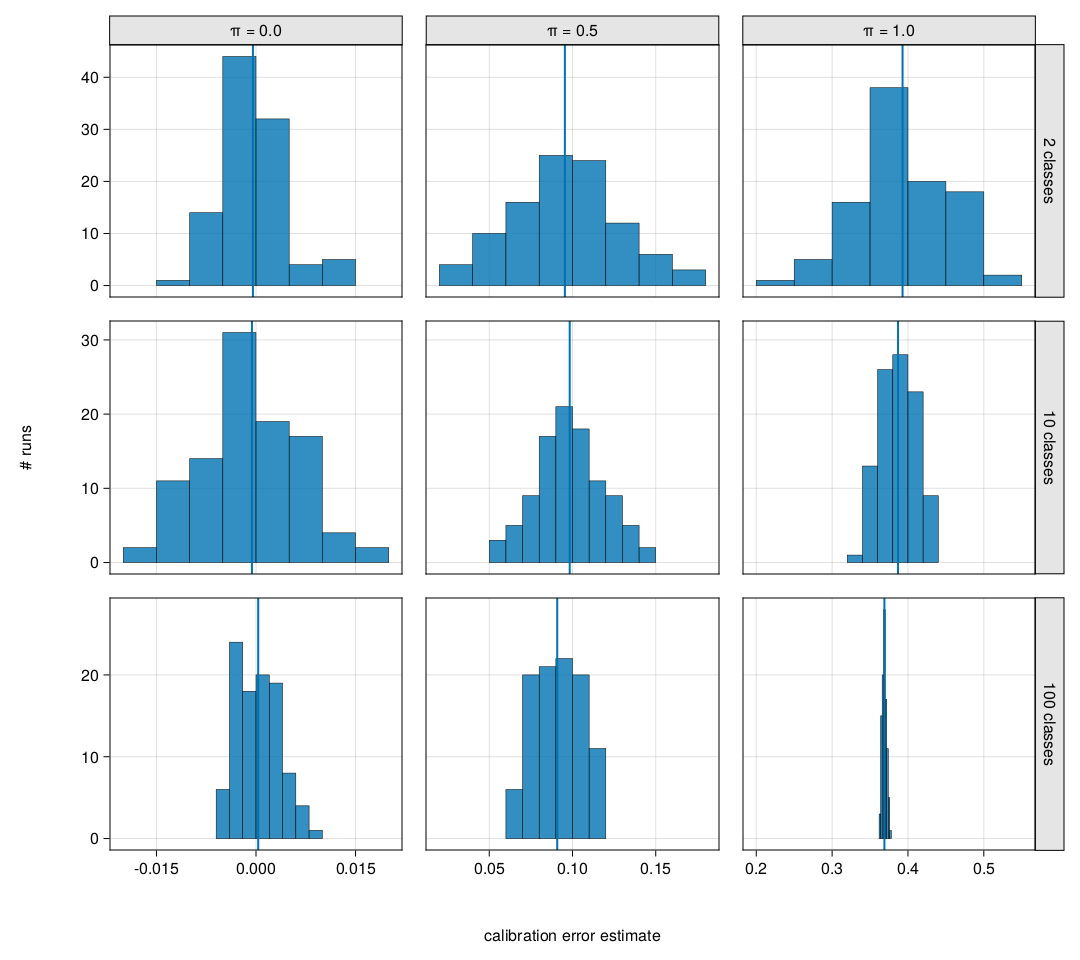

In [8]:
Random.seed!(1234)
data = estimates(SKCE ∘ MedianHeuristicKernel(250))
plot_estimates(data)

Random.seed!(1234)
data = estimates() do predictions_targets
    return SKCE(MedianHeuristicKernel(250)(predictions_targets); blocksize=2)
end
plot_estimates(data)

## Biased estimator of the squared kernel calibration error

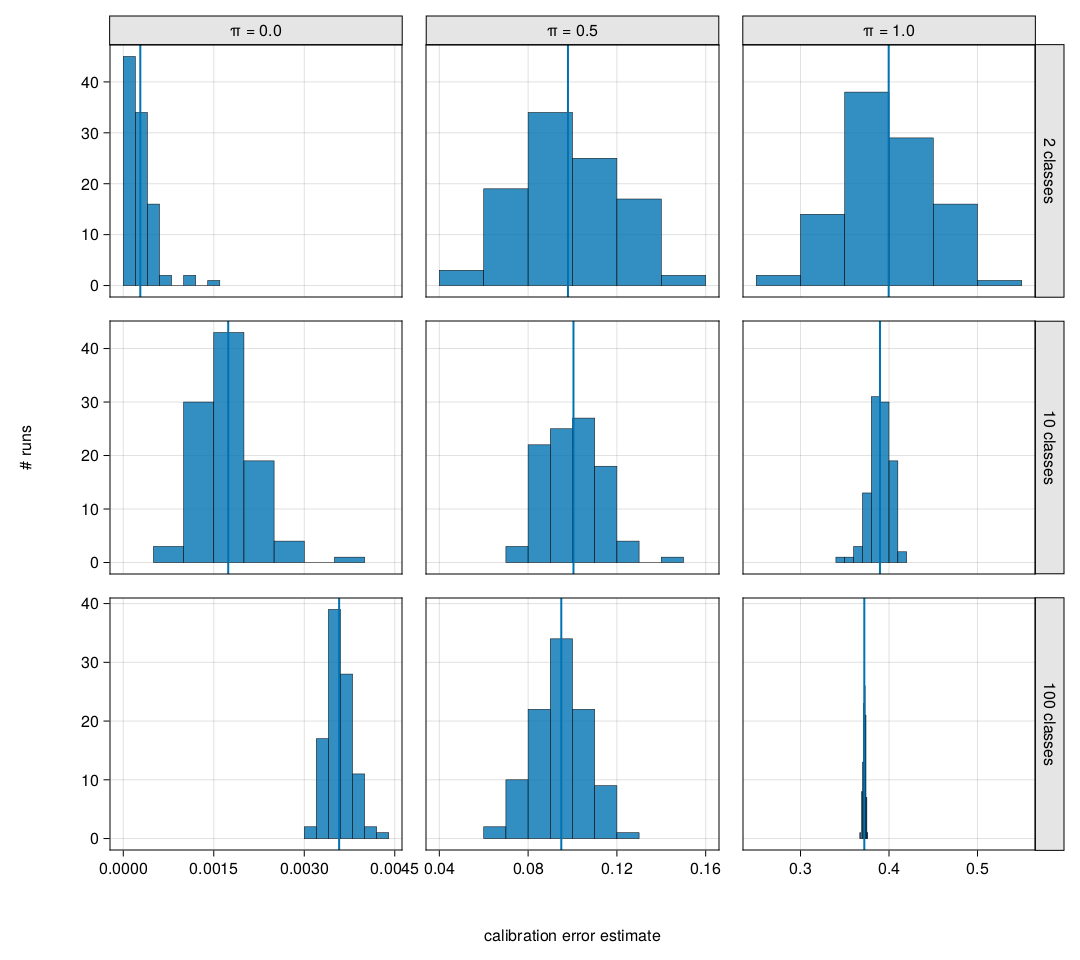

In [9]:
Random.seed!(1234)
data = estimates() do predictions_targets
    return SKCE(MedianHeuristicKernel(250)(predictions_targets); unbiased=false)
end
plot_estimates(data)

### Package and system information
#### Package version
```julia
Status `~/work/CalibrationErrors.jl/CalibrationErrors.jl/examples/distribution/Project.toml`
⌅ [13f3f980] CairoMakie v0.10.12
  [33913031] CalibrationErrors v0.6.4 `~/work/CalibrationErrors.jl/CalibrationErrors.jl`
  [31c24e10] Distributions v0.25.107
  [2913bbd2] StatsBase v0.34.2
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`
```
#### Computer information
```
Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver3)
  Threads: 1 on 4 virtual cores
Environment:
  JULIA_PKG_SERVER_REGISTRY_PREFERENCE = eager
  JULIA_DEBUG = Documenter
  JULIA_LOAD_PATH = :/home/runner/work/CalibrationErrors.jl/CalibrationErrors.jl/docs
```
#### Manifest
To reproduce the project environment of this example you can [download the full Manifest.toml](./Manifest.toml).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*